In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth,SpectralClustering,AffinityPropagation

In [2]:
results = pd.read_csv('2013results.csv')
results.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [3]:
#How many unique values are in each column?
results.nunique()

25k           3245
age             61
name         16137
division      3698
10k           1459
gender           2
half          2761
official      5370
bib          16157
ctz             75
country         68
overall      16107
pace           362
state           65
30k           3862
5k             808
genderdiv     9812
20k           2644
35k           4539
city          4416
40k           5136
dtype: int64

In [4]:
#What types of data are in my dataframe?
results.dtypes

25k           object
age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [5]:
#To clean up my data even further, let's drop columns that don't really have to do with race performance
results_main = results.drop(['name','bib','ctz','country','state','city','division','genderdiv'], axis = 1)
results_main.head()
#can look at bringing country back in if needed
#start small first and do a dataframe with age, gender, overall and pace and see what clustering looks like
#then can look at bringing in other race groupings


,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k
0,49.87,28,18.18,M,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55
1,77.27,30,30.90,M,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77
2,77.23,23,30.90,M,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78
3,50.50,32,18.73,M,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43
4,48.75,39,18.18,M,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88


In [6]:
# Remove hyphens from missing entries
results_main_1 = results_main.replace(to_replace='-', value='')
results_main_1.head()

,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k
0,49.87,28,18.18,M,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55
1,77.27,30,30.90,M,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77
2,77.23,23,30.90,M,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78
3,50.50,32,18.73,M,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43
4,48.75,39,18.18,M,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88


In [7]:
#Convert our race groupings into numeric
race_group = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k' ]
for race_group in race_group:
    results_main_1[race_group] = pd.to_numeric(results_main_1[race_group])

Let's look at a heatmap to see if we have any areas of high correlation.  We have a lot of different race groupings still in the data that might be highly correlated to each other.

Text(0.5, 1.05, 'Correlation of race grouping and gender')

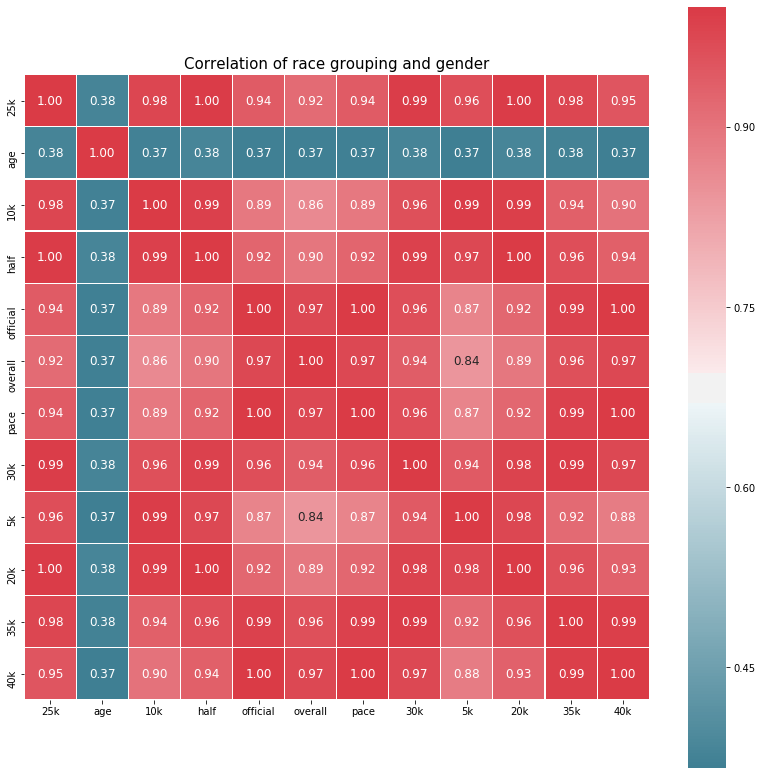

In [8]:
corr = results_main_1.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of race grouping and gender', y=1.05, size=15)

Just as we thought, the different race groupings are heavily correlated to each other.  Let's scrub these columns out of our dataframe and work through our clusters that way first.

In [9]:
results_main_2 = results_main_1.drop(['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k'], axis = 1)
results_main_2.head()

,age,gender,official,overall,pace
0,28,M,90.90,9,3.47
1,30,M,132.50,5,5.07
2,23,M,130.37,1,4.98
3,32,M,88.43,5,3.38
4,39,M,87.22,3,3.33


In [10]:
#Let's change our gender in binary outputs# Binarize gender so 1 = female, 0 = male
results_main_2['gender'] = np.where(results_main_1['gender']=='F', 1, 0)

In [11]:
#Finally, let's drop any NA's
results_main_2.dropna(inplace = True)
results_main_2.head()

,age,gender,official,overall,pace
0,28,0,90.90,9,3.47
1,30,0,132.50,5,5.07
2,23,0,130.37,1,4.98
3,32,0,88.43,5,3.38
4,39,0,87.22,3,3.33


In [12]:
results_main_2.dtypes

age           int64
gender        int64
official    float64
overall       int64
pace        float64
dtype: object

### Time to Cluster!

#### K Means

In [13]:
results_normalize = StandardScaler().fit_transform(results_main_2)

In [14]:
# Define the features and the outcome.
X = results_normalize
#Y = race_splits

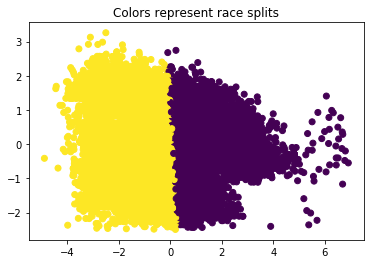

In [15]:
#result_model = normalize(X)

result_pca = PCA(2).fit_transform(X)

result_pred = KMeans(n_clusters=2, random_state=42).fit_predict(result_pca)

plt.scatter(result_pca[:, 0], result_pca[:, 1], c=result_pred)
plt.title('Colors represent race splits')
plt.show()

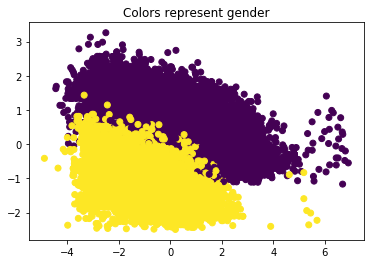

In [16]:
#result_model = normalize(X)

result_pca = PCA(2).fit_transform(X)

result_pred = KMeans(n_clusters=2, random_state=42).fit_predict(result_pca)

plt.scatter(result_pca[:, 0], result_pca[:, 1], c=results_main_2.gender)
plt.title('Colors represent gender')
plt.show()

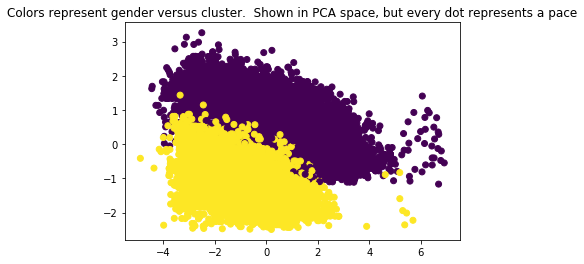

Comparing k-means clusters against the data:
gender     0     1
row_0             
0       6409  1172
1       3271  5312


In [17]:
plt.scatter(result_pca[:, 0], result_pca[:, 1], c=results_main_2.gender)
plt.title('Colors represent gender versus cluster.  Shown in PCA space, but every dot represents a pace')
plt.show()

print('Comparing k-means clusters against the data:')
print(pd.crosstab(result_pred, results_main_2.gender))

In [18]:
results_main_2.shape

(16164, 5)

In [19]:
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=16164)
minibatchkmeans.fit(result_pca)

predict_mini = minibatchkmeans.predict(result_pca)

print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, result_pred))

Comparing k-means and mini batch k-means solutions:
col_0     0     1
row_0            
0         0  8372
1      7581   211


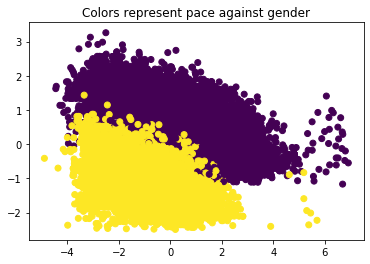

In [20]:
plt.scatter(result_pca[:, 0], result_pca[:, 1], c=results_main_2.gender)
plt.title('Colors represent pace against gender')
plt.show() 

In [21]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

### Mean Shift

In [22]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(results_main_2, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(results_main_2)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))



Number of estimated clusters: 4


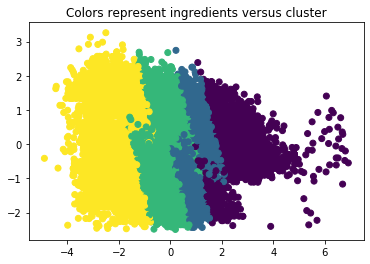

Comparing the assigned categories to the ones in the data:
col_0      0     1     2     3
gender                        
0       3200  1970  2541  1969
1        248   659  2515  3062


In [23]:
plt.scatter(result_pca[:, 0], result_pca[:, 1], c=labels)
plt.title('Colors represent ingredients versus cluster')
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(results_main_2.gender,labels))

### Spectral Clustering

In [24]:
#for n_cluster in range(2, 7):

# Declare and fit the model.
    #sc = SpectralClustering(n_clusters=2)
    #sc.fit(X)

#Predicted clusters.
    #predict=sc.fit_predict(X)
    #sil_coeff = silhouette_score(X, predict, metric='euclidean')
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#Graph results.
    #plt.scatter(X[:, 0], X[:, 1], c=predict)
    #plt.show()

### Affinity Propagation

In [25]:
#affinity_P = AffinityPropagation().fit(X)
#print('Done')

# Pull the number of clusters and cluster assignments for each data point.
#cluster_centers_indices = af.cluster_centers_indices_
#n_clusters_ = len(cluster_centers_indices)
#labels = affinity_P.labels_

#print('Estimated number of clusters: {}'.format(n_clusters_))
#sil_coeff = silhouette_score(X, labels, metric='euclidean')
#print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

### TSNE

In [26]:
from sklearn.manifold import TSNE

In [27]:
test = TSNE(n_components=2)
#test.fit_transform(np.array(X1))
test2 = test.fit_transform(np.array(results_main_2))
test2.shape

(16164, 2)

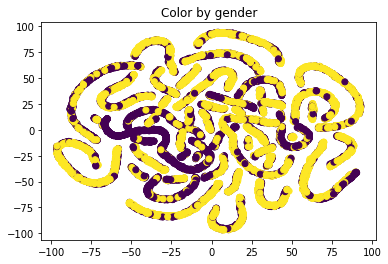

In [28]:
plt.scatter(test2[:, 0], test2[:, 1], c=results_main_2.gender)
plt.title('Color by gender')
plt.show()